# Project: English-German Translator

In this notebook, we will build an English to German neural machine traslator using a Encoder-Decoder architecture. In order to improve its performance on long and complex sequences, we will add an attention layer to the model. 

This notebook is part of the post [Neural Machine Translation with Attention – Project: English-German Translator](https://mathchine-learning.blogspot.com/2020/09/neural-machine-translation-with.html). I recommend reading the post before going any further in this notebook.

## Table of contents
- [1.  Data in machine translation](#1)
    - [1.1  Importing the libraries and loading the data](#1.1)
    - [1.2  Tokenization and detokenization](#1.2)
    - [1.3  Bucketing](#1.3)
    - [1.4  Exploring the data](#1.4)
- [2.  Neural Machine Translation with Attention](#2)
    - [2.1  Encoder-Decoder architecture](#2.1)
    - [2.2  Attention mechanism](#2.2)
    - [2.3  Main parts of our model](#2.3)
        - [2.3.1  Encoder](#2.3.1)
        - [2.3.1  Pre-attention Decoder](#2.3.2)
        - [2.3.1  Decoder](#2.3.3)
        - [2.3.1  Preparation function for the attention layer](#2.3.4)
    - [2.4  The model implementation](#2.4)
- [3.  Training](#3)
    - [3.1  Train task](#3.1)
    - [3.2  Evaluation task](#3.2)
    - [3.3  Loop](#3.3)
    - [3.4  Start training](#3.4)
    - [3.5  Load pretrained weights](#3.5)
- [4.  Testing](#4)
    - [4.1  Decoding](#4.1)
    - [4.2  Greedy decoding](#4.2)
    - [4.3  Minimum Bayes-risk decoding](#4.3)

<a name="1"></a>
# 1. Data in machine translation

<a name="1.1"></a>
## 1.1 Importing the libraries and loading the data

First, we will import the packages we will need in this project. Since there is already a lot of content on the web using pytorch and tensorflow, we will use Trax, an end-to-end library for deep learning that focuses on clear code and speed, actively used and maintained by the Google Brain team, as I belive in the near future it will become the meta library for deep learning. However, you can implement the same model using other frameworks like pyTorch or Tensorflow, as both provide the tools required for this task. 

In [ ]:
# Install trax if needed: 
!pip install trax

In [ ]:
import random
import numpy as np
import os

import trax
from trax import layers as tl
from trax.fastmath import numpy as fastnp
from trax.supervised import training

from termcolor import colored

Next, we will load the dataset we will use to train our model. We will use opus/medical, a small medical related corpus, since this projects purpose is learning. For a more realistic scenario, you can opt to get a larger corpus such as ParaCrawl, a large multi-lingual translation dataset created by the European Union. 

Both datasets are available via [Tensorflow Datasets](https://www.tensorflow.org/datasets). 

In [ ]:
# Get generator function for the training set
# This will download the train dataset if it is not found in data_dir.
train_stream_fn = trax.data.TFDS('opus/medical',
                                 data_dir='./data/',
                                 keys=('en', 'de'),
                                 eval_holdout_size=0.01, # 1% for eval
                                 train=True)

# Get generator function for the eval set
# This will download the eval dataset if it is not found in data_dir.
eval_stream_fn = trax.data.TFDS('opus/medical',
                                data_dir='./data/',
                                keys=('en', 'de'),
                                eval_holdout_size=0.01, # 1% for eval
                                train=False)

Notice that TFDS returns a generator function, not a generator. This is because in Python, you cannot reset generators so you cannot go back to a previously yielded value and sometimes its good to be able to do that. Now, we will print a sample pair from our train and eval data. 

In [ ]:
#First, we initialize our train data generator
train_stream = train_stream_fn()
#Then we print one value
print(colored('train data (en, de) tuple:', 'red'), next(train_stream))
print()

#First, we initialize our test data generator
eval_stream = eval_stream_fn()
print(colored('eval data (en, de) tuple:', 'red'), next(eval_stream))

train data (en, de) tuple: (b'During treatment with olanzapine, adolescents gained significantly more weight compared with adults.\n', b'W\xc3\xa4hrend der Behandlung mit Olanzapin nahmen die Jugendlichen im Vergleich zu Erwachsenen signifikant mehr Gewicht zu.\n')

eval data (en, de) tuple: (b'Lutropin alfa Subcutaneous use.\n', b'Pulver zur Injektion Lutropin alfa Subkutane Anwendung\n')


Now, we have to preprocess our sentences into a format that our model can read.

### Download required files

The following files are needed:
- A English-German subwords vocabulary that we are going to use for tokenization (1mb -).
- Pretrained weights for the network, obtained after several days of training (1gb +).

Both files can be found in [this folder](https://drive.google.com/drive/folders/1fWznMxhX_ygXufbAggtehN4pv5E7MN_7?usp=sharing). Download and save everything in drive.

<a name="1.2"></a>
## 1.2 Tokenization and detokenization

First, we tokenize our corpus using subword representations. This is a common technique to avoid out-of-vocabulary words by allowing parts of words to be represented separately. For example, instead of having separate entries in your vocabulary for "fear", "fearless", "fearsome", "some", and "less", we simply store "fear", "some", and "less", then allow your tokenizer to combine these subwords when needed.


In [ ]:
# Subwords vocabulary directory
VOCAB_FILE = 'ende_32k.subword'
VOCAB_DIR = '/content/drive/My Drive/Proyectos/Project: English-German Translator/'

# Tokenize the dataset using subwords
tokenized_train_stream = trax.data.Tokenize(vocab_file=VOCAB_FILE, vocab_dir=VOCAB_DIR)(train_stream)
tokenized_eval_stream = trax.data.Tokenize(vocab_file=VOCAB_FILE, vocab_dir=VOCAB_DIR)(eval_stream)

Second, we append an end-of-sentence token to each sentence: we will assign a token (in this case 1) to mark the end of a sentence. This will be useful in inference so we will know that the model has completed the translation.

In [ ]:
# Integer assigned as end-of-sentence (EOS)
EOS = 1

# We create a generator function to append EOS to each sentence
def append_eos(stream):
    for (inputs, targets) in stream:
        inputs_with_eos = list(inputs) + [EOS]
        targets_with_eos = list(targets) + [EOS]
        yield np.array(inputs_with_eos), np.array(targets_with_eos)

# Generator functions with appended EoS at the end of each sentence
tokenized_train_stream = append_eos(tokenized_train_stream)

tokenized_eval_stream = append_eos(tokenized_eval_stream)

Third, we will force a limit on the number of tokens per sentence to ensure we will not run out of memory.

In [ ]:
# The length_keys=[0, 1] means we filter both English and German sentences to a
# max of 256 tokens for training and 512 for test.
filtered_train_stream = trax.data.FilterByLength(
    max_length=256, length_keys=[0, 1])(tokenized_train_stream)
filtered_eval_stream = trax.data.FilterByLength(
    max_length=512, length_keys=[0, 1])(tokenized_eval_stream)

Finally, let's display a input-target pair of tokenized sentences.

In [ ]:
train_input, train_target = next(filtered_train_stream)
print(colored(f'Single tokenized example input:', 'red' ), train_input)
print(colored(f'Single tokenized example target:', 'red'), train_target)

Single tokenized example input: [14026  2801  3551 32955   135   150 14443 22008 21980   332 30650  4729
   992     1]
Single tokenized example target: [14026  2801  3551 32955   135   150 14443 22008 21980   332 30650  4729
   992     1]


### Tokenize and Detokenize functions

Given any data set, we have to be able to map words to their indices, and indices to their words. Thats what the following helper functions do.

*   tokenize(): converts a text sentence to its corresponding token list (i.e. list of indices). Also converts words to subwords (parts of words).
*   detokenize(): converts a token list to its corresponding sentence (i.e. string).





In [ ]:
def tokenize(input_str, vocab_file=None, vocab_dir=None):
    """Encodes a string to an array of integers

    Args:
        input_str (str): human-readable string to encode
        vocab_file (str): filename of the vocabulary text file
        vocab_dir (str): path to the vocabulary file
  
    Returns:
        numpy.ndarray: tokenized version of the input string
    """
    
    # Set the encoding of the "end of sentence" as 1
    EOS = 1
    
    # Use the trax.data.tokenize method. It takes streams and returns streams,
    # we get around it by making a 1-element stream with `iter`.
    inputs =  next(trax.data.tokenize(iter([input_str]),
                                      vocab_file=vocab_file, vocab_dir=vocab_dir))
    
    # Mark the end of the sentence with EOS
    inputs = list(inputs) + [EOS]
    
    # Adding the batch dimension to the front of the shape
    batch_inputs = np.reshape(np.array(inputs), [1, -1])
    
    return batch_inputs


def detokenize(integers, vocab_file=None, vocab_dir=None):
    """Decodes an array of integers to a human readable string

    Args:
        integers (numpy.ndarray): array of integers to decode
        vocab_file (str): filename of the vocabulary text file
        vocab_dir (str): path to the vocabulary file
  
    Returns:
        str: the decoded sentence.
    """
    
    # Remove the dimensions of size 1
    integers = list(np.squeeze(integers))
    
    # Set the encoding of the "end of sentence" as 1
    EOS = 1
    
    # Remove the EOS to decode only the original tokens
    if EOS in integers:
        integers = integers[:integers.index(EOS)] 
    
    return trax.data.detokenize(integers, vocab_file=vocab_file, vocab_dir=vocab_dir)

In [ ]:
# Detokenize an input-target pair of tokenized sentences
print(colored(f'Single detokenized example input:', 'red'), detokenize(train_input, vocab_file=VOCAB_FILE, vocab_dir=VOCAB_DIR))
print(colored(f'Single detokenized example target:', 'red'), detokenize(train_target, vocab_file=VOCAB_FILE, vocab_dir=VOCAB_DIR))
print()

# Tokenize and detokenize a word that is not explicitly saved in the vocabulary file
# See how it combines the subwords -- 'hell' and 'o'-- to form the word 'hello'
print(colored(f"tokenize('hello'): ", 'green'), tokenize('hello', vocab_file=VOCAB_FILE, vocab_dir=VOCAB_DIR))
print(colored(f"detokenize([17332, 140, 1]): ", 'green'), detokenize([17332, 140, 1], vocab_file=VOCAB_FILE, vocab_dir=VOCAB_DIR))

Single detokenized example input: Tel: +421 2 57 103 777

Single detokenized example target: Tel: +421 2 57 103 777


tokenize('hello'):  [[17332   140     1]]
detokenize([17332, 140, 1]):  hello


<a name="1.3"></a>
## 1.3 Bucketing

Bucketing the tokenized sentences is an important technique used to speed up training in NLP. The gist is very simple: our inputs have variable lengths and we want to make these the same when batching groups of sentences together. One way to do that is to pad each sentence to the length of the longest sentence in the dataset. 

We batch the sentences with similar length together and only add minimal padding to make them have equal length (usually up to the nearest power of two). This allows to waste less computation when processing padded sequences. 

In [ ]:
# Bucketing to create streams of batches.

# Buckets are defined in terms of boundaries and batch sizes.
# Batch_sizes[i] determines the batch size for items with length < boundaries[i]
# So below, we will take a batch of 256 sentences of length < 8, 128 if length is
# between 8 and 16, and so on -- and only 2 if length is over 512.
boundaries =  [8,   16,  32, 64, 128, 256, 512]
batch_sizes = [256, 128, 64, 32, 16,    8,   4,  2]

# We create the generators
train_batch_stream = trax.data.BucketByLength(
    boundaries, batch_sizes,
    length_keys=[0, 1]  
)(filtered_train_stream)

eval_batch_stream = trax.data.BucketByLength(
    boundaries, batch_sizes,
    length_keys=[0, 1]  
)(filtered_eval_stream)

# Add masking for the padding (0s).  #[0] en, [1] de, [2] padding mask
train_batch_stream = trax.data.AddLossWeights(id_to_mask=0)(train_batch_stream)
eval_batch_stream = trax.data.AddLossWeights(id_to_mask=0)(eval_batch_stream)

<a name="1.4"></a>
## 1.4 Exploring the data

First, we get the data generator and get one batch of the data.

In [ ]:
input_batch, target_batch, mask_batch = next(train_batch_stream)

# Print data type
print("input_batch data type: ", type(input_batch))
print("target_batch data type: ", type(target_batch))

# Print the shape
print("input_batch shape: ", input_batch.shape)
print("target_batch shape: ", target_batch.shape)

input_batch data type:  <class 'numpy.ndarray'>
target_batch data type:  <class 'numpy.ndarray'>
input_batch shape:  (32, 64)
target_batch shape:  (32, 64)


We can now visually inspect some of the data. You can run the cell below several times to shuffle through the sentences. Just to note, while this is a standard data set that is used widely, it does have some known wrong translations.

In [ ]:
# Pick a random index less than the batch size.
index = random.randrange(len(input_batch))

# Use the index to grab an entry from the input and target batch
print(colored('THIS IS THE ENGLISH SENTENCE: \n', 'red'), detokenize(input_batch[index], vocab_file=VOCAB_FILE, vocab_dir=VOCAB_DIR), '\n')
print(colored('THIS IS THE TOKENIZED VERSION OF THE ENGLISH SENTENCE: \n ', 'red'), input_batch[index], '\n')
print(colored('THIS IS THE GERMAN TRANSLATION: \n', 'red'), detokenize(target_batch[index], vocab_file=VOCAB_FILE, vocab_dir=VOCAB_DIR), '\n')
print(colored('THIS IS THE TOKENIZED VERSION OF THE GERMAN TRANSLATION: \n', 'red'), target_batch[index], '\n')

THIS IS THE ENGLISH SENTENCE: 
 DATE OF FIRST AUTHORISATION/RENEWAL OF THE AUTHORISATION
 

THIS IS THE TOKENIZED VERSION OF THE ENGLISH SENTENCE: 
  [14344   493 11544  9868 18207   693  9227  7933 10547  3337  4205 10617
   123  3234  4017 13986  1047 11544  4327  9227  7933 10547  3337  4205
 10617 30650  4729   992     1     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0] 

THIS IS THE GERMAN TRANSLATION: 
 DATUM DER ERTEILUNG DER ERSTZULASSUNG / VERLÄNGERUNG DER ZULASSUNG
 

THIS IS THE TOKENIZED VERSION OF THE GERMAN TRANSLATION: 
 [14344 11459     5  9192  6304  6999  8001 18044  9192  6304 14075  1834
 25057  8066  8462 11553  1962 10468  2474  3449  9797  6304 18044  9192
  1834 25057  8066  8462 11553 30650  4729   992     1     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
  

Now that our data is preprocessed, we will build our model.

<a name="2"></a>
# 2. Neural Machine Translation with Attention

The model we will be building uses an encoder-decoder architecture. This Recurrent Neural Network (RNN) will take in a tokenized version of a sentence in its encoder, then passes it on to the decoder for translation. Just using a regular sequence-to-sequence model with LSTMs will work effectively for short to medium sentences but will start to degrade for longer ones. Adding an attention mechanism to this model avoids this problem by giving the decoder a way to learn where to focus its attention on the input sequence, as each word of the output sequence is decoded.

In this section, we will first introduce the Encoder-Decoder architecture. Then, we will describe how an attention mechanism works. Finally,  we will implement a model using Encoder-Decoder architecture with attention.

<a name="2.1"></a>
## 2.1 Encoder-Decoder architecture

The Encoder–Decoder architecture idea is simple: the encoder neural network reads and encodes a source sentence into a fixed length vector, then the decoder outputs the translation from the encoded vector. The whole encoder-decoder network is jointly trained to maximize the probability of a correct translation given a source sentence.

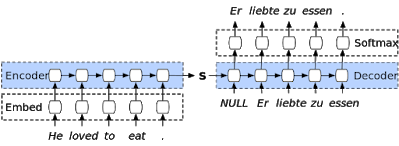

<a name="2.2"></a>
## 2.2 Attention mechanism

Now, let's see how attention works. To illustrate, we will just use a 4-word input sentence as shown below. Remember that a hidden state is produced at each timestep of the encoder (represented by the orange rectangles). These are all passed to the attention layer and each are given a score given the current activation (i.e. hidden state) of the decoder. 

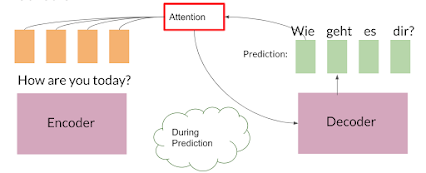

For instance, consider the figure above where the first prediction “Wie” is already made. To produce the next prediction, the attention layer will first receive all the encoder hidden states (i.e. orange rectangles) as well as the decoder hidden state when producing the word “Wie” (i.e. first green rectangle). Given this information, it will score each of the encoder hidden states to know which one the decoder should focus on to produce the next word. The result of the model training might have learned that it should align to the second encoder hidden state and subsequently assigns a high probability to the word “geht”. If we are using a greedy algorithm for decoding, we will output the said word as the next symbol, then restart the process to produce the next word until we reach an end-of-sentence prediction.

There are different ways to score the encoder hidden states, but the one we will use here is the scaled dot product attention:

$$Attention(Q, K, V) = softmax(\frac{Q\cdot K^T}{\sqrt{d_k}})V$$

For our machine translation application, the encoder activations (i.e. encoder hidden states) will be the keys (K) and values (V), while the decoder activations (i.e. decoder hidden states) will be the queries (Q). Dont forget that Q, K and V are matrices.

You can think of it as computing the scores using the dot product between the queries and keys matrices, which measures their similarity. Then softmaxing after dividing by the square root of the keys dimensionality ($\sqrt{d_k}$). And finally, computing the dot product between this and the values, to get the attention vector at a particular timestep of the decoder.

You can read more about attention in the original “[Attention is all you need](http://papers.nips.cc/paper/7181-attention-is-all-you-need.pdf)” paper.

<a name="2.3"></a>
## 2.3 Main parts of our model

In this section we will define the main parts of our model. We will implement the input encoder, the pre-attention decoder, the decoder and a preparation function for the attention layer that we will describe later.

<a name="2.3.1"></a>
### 2.3.1 Encoder

The encoder has the tokenized sentences in the source language as input. It creates the word embedding, converts the one-hot encoded sentences into vectors of the embedding and then feeds the vectors into a LSTM network. This outputs the activations (hidden states) that will be the keys and values for attention.

In [ ]:
def input_encoder_fn(input_vocab_size, d_model, n_encoder_layers):
    """ Input encoder runs on the input sentence and creates
    activations that will be the keys and values for attention.
    
    Args:
        input_vocab_size: int: vocab size of the input
        d_model: int:  depth of embedding (n_units in the LSTM cell)
        n_encoder_layers: int: number of LSTM layers in the encoder
    Returns:
        tl.Serial: The input encoder
    """
    
    # We create a serial network
    input_encoder = tl.Serial( 
        
        # We create an embedding layer to convert tokens to vectors
        tl.Embedding(input_vocab_size, d_model),
        
        # We feed the embedded vectors to the stack of LSTMs
        [tl.LSTM(d_model) for _ in range(n_encoder_layers)]
    )

    return input_encoder

<a name="2.3.2"></a>
### 2.3.2 Pre-attention Decoder

The pre-attention decoder is responsible of feeding the queries to the attention layer. It has the tokenized sentences in the target language as input. It creates the word embedding, converts the one-hot encoded sentences into vectors of the embedding and then feeds the vectors into a LSTM network. 

Teacher forcing is a strategy for training RNNs quicker and more efficiently. It is described in [A Learning Algorithm for Continually Running Fully Recurrent Neural Networks](http://ieeexplore.ieee.org/document/6795228/) in the following manner.

> An interesting technique that is frequently used in dynamical supervised learning tasks is to replace the actual output y(t) of a unit by the teacher signal d(t) in subsequent computation of the behavior of the network, whenever such a value exists. We call this technique teacher forcing.

Essentially, teacher forcing works by using the actual output from the training dataset at the current timestep t as input in the next timestep rather than the output generated by the network. In our model, instead of feeding the attention layer with the prediction from the decoder, we feed it with the ground truth translation.

As we want to implement teacher forcing training, we have to add a ShiftRight layer to the pre-attention decoder.

In [ ]:
def pre_attention_decoder_fn(mode, target_vocab_size, d_model):
    """ Pre-attention decoder runs on the targets and creates
    activations that are used as queries in attention.
    
    Args:
        mode: str: 'train' or 'eval'
        target_vocab_size: int: vocab size of the target
        d_model: int:  depth of embedding (n_units in the LSTM cell)
    Returns:
        tl.Serial: The pre-attention decoder
    """
    
    # We create a serial network
    pre_attention_decoder = tl.Serial(
        
        # We shift right in order to implement teacher forcing
        tl.ShiftRight(),

        # We run an embedding layer to convert tokens into vectors
        tl.Embedding(target_vocab_size, d_model),

        # We feed to an LSTM layer
        tl.LSTM(d_model)
    )
    
    return pre_attention_decoder

<a name="2.3.3"></a>
### 2.3.3 Decoder

The decoder architecture is straightforward. It receives the attentionQKV layer activations as input, which contain the fixed length vector and the attention information. It consists in just a stack of multiple LSTM layers.

In [ ]:
def decoder_fn(d_model, n_decoder_layers):
    """ Decoder runs on the attentionQKV activations
    
    Args:
        d_model: int:  depth of embedding (n_units in the LSTM cell)
        n_decoder_layers: int: number of LSTM layers in the encoder
    Returns:
        tl.Serial: The decoder
    """
    
    # We create a serial network
    decoder = tl.Serial( 
             
        # We feed the attentionQKV activations to the stack of LSTMs
        [tl.LSTM(d_model) for _ in range(n_decoder_layers)]
    )

    return decoder

<a name="2.3.4"></a>
### 2.3.4 Preparation function for the attention layer


This function will be preparing the inputs to the attention layer. It will take in the encoder and pre-attention decoder hidden states and assign them to the queries, keys and values. In addition, it will add a mask to distinguish real tokens from padding tokens. This mask is used internally by Trax when cumputing softmax so padding tokens will not affect the computed probabilities.

In [ ]:
def prepare_attention_input(encoder_activations, decoder_activations, inputs):
    """Prepare queries, keys, values and mask for attention.
    
    Args:
        encoder_activations fastnp.array(batch_size, padded_input_length, d_model): output from the input encoder
        decoder_activations fastnp.array(batch_size, padded_input_length, d_model): output from the pre-attention decoder
        inputs fastnp.array(batch_size, padded_input_length): padded input tokens
    
    Returns:
        queries, keys, values and mask for attention.
    """
    
    # We set the keys and values to the encoder activations (encoder hidden states)
    keys = encoder_activations
    values = encoder_activations
    
    # We set the queries to the decoder activations (pre-att decoder hidden states)
    queries = decoder_activations
    
    # We generate the mask to distinguish real tokens from padding
    mask = inputs > 0
   
    # We add axes to the mask for attention heads and decoder length
    mask = fastnp.reshape(mask, (mask.shape[0], 1, 1, mask.shape[1]))
    
    # Broadcast so mask shape is [batch size, attention heads, decoder-len, encoder-len].
    mask = mask + fastnp.zeros((1, 1, decoder_activations.shape[1], 1))
    
    return queries, keys, values, mask

<a name="2.4"></a>
## 2.4 The model implementation

We are going to implement the following model.

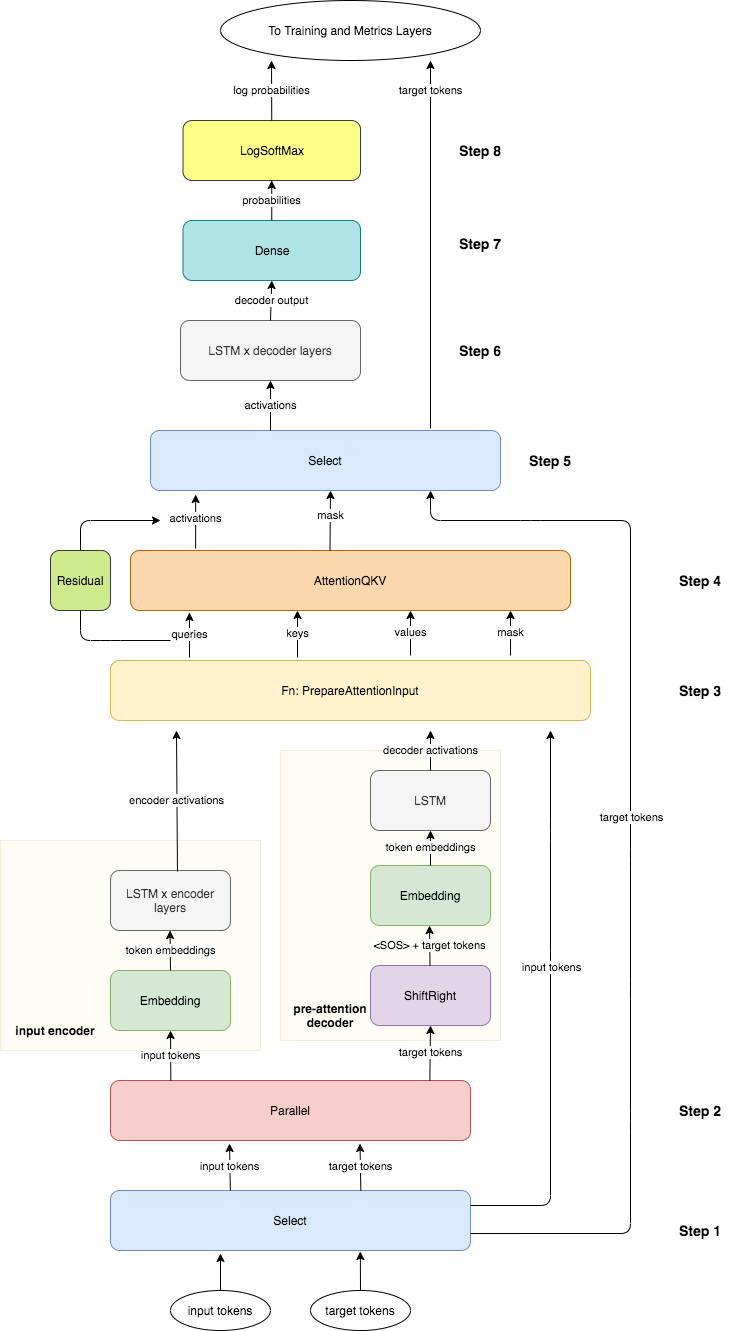

Although it seems a bit complicated, the implementation is quite straightforward if we follow the steps in the figure and we use the functions that we have previously created. 

In [ ]:
def NMTAttn(input_vocab_size=33300,
            target_vocab_size=33300,
            d_model=1024,
            n_encoder_layers=2,
            n_decoder_layers=2,
            n_attention_heads=4,
            attention_dropout=0.0,
            mode='train'):
    """Returns an LSTM sequence-to-sequence model with attention.

    The input to the model is a pair (input tokens, target tokens).
    E.g., a tokenized English sentence and its tokenized translation into German.

    Args:
    input_vocab_size: int: vocab size of the input
    target_vocab_size: int: vocab size of the target
    d_model: int:  depth of embedding (n_units in the LSTM cell)
    n_encoder_layers: int: number of LSTM layers in the encoder
    n_decoder_layers: int: number of LSTM layers in the decoder after attention
    n_attention_heads: int: number of attention heads
    attention_dropout: float, dropout for the attention layer
    mode: str: 'train', 'eval' or 'predict', predict mode is for fast inference

    Returns:
    A LSTM sequence-to-sequence model with attention.
    """
   
    # Step 0: We create the encoder
    input_encoder =  input_encoder_fn(input_vocab_size, d_model, n_encoder_layers)

    # Step 0: We create the pre-attention decoder
    pre_attention_decoder = pre_attention_decoder_fn(mode, target_vocab_size, d_model)

    # Step 0: We create the decoder
    decoder = decoder_fn(d_model, n_decoder_layers)

    # Step 1: Now, we create a serial model
    model = tl.Serial(       
      # Step 2: First, we copy input tokens and target tokens as they will be needed later
      tl.Select([0, 1, 0, 1]),
        
      # Step 3: Then, run encoder on the input tokens and pre-attention decoder on the target tokens using a Parallel layer
      tl.Parallel(input_encoder, pre_attention_decoder),
        
      # Step 4: At this point we have the encoder hidden states and the pre_attention_decoder hidden states,
      # we pass them into the preparation function in order to prepare queries, keys, values and mask for attention.
      tl.Fn('PrepareAttentionInput', prepare_attention_input, n_out=4),
        
      # Step 5: Now, we run the AttentionQKV layer.
      # We nest it inside a Residual layer to add to the attention layer output the pre-attention decoder activations (queries)
      # that will be used for teacher forcing
      tl.Residual(tl.AttentionQKV(d_model, n_heads=n_attention_heads, dropout=attention_dropout, mode=mode)),
      
      # Step 6: We drop attention mask (index 1)
      tl.Select([0, 2]),
        
      # Step 7: We pass the attention layer output and the queries into our decoder
      decoder,
        
      # Step 8: Then, we prepare the output by making it the right size with a dense layer
      tl.Dense(target_vocab_size),
        
      # Step 9: Finally, we Log-softmax te result
      tl.LogSoftmax()
    )
        
    return model

In [ ]:
# We display our model architecture
model = NMTAttn()
print(model)

Serial_in2_out2[
  Select[0,1,0,1]_in2_out4
  Parallel_in2_out2[
    Serial[
      Embedding_33300_1024
      LSTM_1024
      LSTM_1024
    ]
    Serial[
      Serial[
        AssertShape
        ShiftRight(1)
        AssertShape
      ]
      Embedding_33300_1024
      LSTM_1024
    ]
  ]
  PrepareAttentionInput_in3_out4
  Serial_in4_out2[
    Branch_in4_out3[
      None
      Serial_in4_out2[
        AssertShape_in4_out4
        Serial_in4_out2[
          Parallel_in3_out3[
            Dense_1024
            Dense_1024
            Dense_1024
          ]
          PureAttention_in4_out2
          Dense_1024
        ]
        AssertShape_in2_out2
      ]
    ]
    Add_in2
  ]
  Select[0,2]_in3_out2
  Serial[
    LSTM_1024
    LSTM_1024
  ]
  Dense_33300
  LogSoftmax
]


<a name="3"></a>
# 3. Training

Now, we will train our model in Trax. To do that, we have to instatiate three classes: TrainTask, EvalTask and Loop.

<a name="3.1"></a>
## 3.1 Train task

The TrainTask class in Trax allows us to define the labeled data we are going to use for training and the mechanisms to compute the loss and update the weights. In our case, we are going to use cross entropy loss and Adam optimizer with a learning rate 0.01. We will also add a decay to the learning rate and save a checkpoint every 10 steps.

In [ ]:
train_task = training.TrainTask(    
    labeled_data= train_batch_stream,    
    loss_layer= tl.CrossEntropyLoss(),    
    optimizer= trax.optimizers.Adam(0.01),    
    lr_schedule= trax.lr.warmup_and_rsqrt_decay(n_warmup_steps = 1000, max_value = 0.01),    
    n_steps_per_checkpoint= 10,
)

<a name="3.2"></a>
## 3.2 Evaluation task

The EvalTask class in Trax is used to track how well the model is doing while training. In our case, we want it to report the cross entropy loss and accuracy.

In [ ]:
eval_task = training.EvalTask(    
    # We tell Trax what data we will use for evaluation
    labeled_data=eval_batch_stream,    
    metrics=[tl.CrossEntropyLoss(), tl.Accuracy()],
)

<a name="3.3"></a>
## 3.3 Loop

The Loop class defines the model we will train as well as the train and eval tasks to execute. Its `run()` method allows us to execute the training for a specified number of steps.

In [ ]:
# We define the output directory
output_dir = '/content/output_dir'

# Remove pre-existing saved models
!rm -f ~/output_dir/model.pkl.gz  

# We define the training loop
training_loop = training.Loop(NMTAttn(mode='train'),
                              train_task,
                              eval_tasks=[eval_task],
                              output_dir=output_dir)

<a name="3.4"></a>
## 3.4 Start training


Execute the training loop. It takes around 10 minutes to complete the 100 epochs.

In [ ]:
training_loop.run(100)


Step      1: Total number of trainable weights: 148492820
Step      1: Ran 1 train steps in 81.29 secs
Step      1: train CrossEntropyLoss |  10.40654182
Step      1: eval  CrossEntropyLoss |  10.39884377
Step      1: eval          Accuracy |  0.00000000

Step     10: Ran 9 train steps in 97.14 secs
Step     10: train CrossEntropyLoss |  10.23781872
Step     10: eval  CrossEntropyLoss |  10.01589489
Step     10: eval          Accuracy |  0.01420679

Step     20: Ran 10 train steps in 74.99 secs
Step     20: train CrossEntropyLoss |  9.43671703
Step     20: eval  CrossEntropyLoss |  8.58469677
Step     20: eval          Accuracy |  0.04581245

Step     30: Ran 10 train steps in 80.40 secs
Step     30: train CrossEntropyLoss |  7.94441175
Step     30: eval  CrossEntropyLoss |  7.40538931
Step     30: eval          Accuracy |  0.02601626

Step     40: Ran 10 train steps in 73.49 secs
Step     40: train CrossEntropyLoss |  7.25300598
Step     40: eval  CrossEntropyLoss |  7.68096161
Step 

<a name="3.5"></a>
## 3.5 Load pretrained weights

We will now load pretrained weights for the model we just built. This weights were obtained by training this model for several days.

In [ ]:
# Instantiate the model we built in eval mode in order to make tests later
model = NMTAttn(mode='eval')

# Initialize weights from a pre-trained model
WEIGHTS_DIR = '/content/drive/My Drive/Proyectos/Project: English-German Translator/'
WEIGHTS_FILE = os.path.join(WEIGHTS_DIR,'model.pkl.gz')

model.init_from_file(WEIGHTS_FILE, weights_only=True)
model = tl.Accelerate(model)

<a name="4"></a>
# 4. Testing

<a name="4.1"></a>
## 4.1 Decoding

We will now be using the model we just built to translate English sentences to German. We will implement this with two functions: 

*   The first one allows us to identify the next symbol (i.e. output token), given a tokenized representation of an sentence (in English) and a tokenized representation of translated words (in German). 
*   The second one takes care of combining the entire translated string. This function calls the next symbol function several times until the nexxt output is the EoS token. It takes in an input string and returns the translated vversion of that string.

In [ ]:
def next_symbol(NMTAttn, input_tokens, cur_output_tokens, temperature):
    """Returns the index of the next token.

    Args:
        NMTAttn (tl.Serial): An LSTM sequence-to-sequence model with attention.
        input_tokens (np.ndarray 1 x n_tokens): tokenized representation of the input sentence
        cur_output_tokens (list): tokenized representation of previously translated words
        temperature (float): parameter for sampling ranging from 0.0 to 1.0.
            0.0: same as argmax, always pick the most probable token
            1.0: sampling from the distribution (can sometimes say random things)

    Returns:
        int: index of the next token in the translated sentence
        float: log-probability of the next symbol
    """

    # Set the length of the current output tokens
    token_length = len(cur_output_tokens)
    
    # Calculate next power of 2 for padding length 
    padded_length = int(2**np.ceil(np.log2(token_length + 1)))
    
    # Pad cur_output_tokens up to the padded_length
    padded = cur_output_tokens + [0] * int(padded_length - token_length)

    # Do not forget that model expects the output to have an axis for the batch size in front so
    # convert padded list to a numpy array with shape (<batch_size>, <padded_length>)
    padded_with_batch = np.expand_dims(np.array(padded), axis=0) 
    
    # Now, we get the prediction
    output, _ = NMTAttn((input_tokens, padded_with_batch))
        
    # From the output we get the log probabilities from the last token output
    log_probs = output[0, token_length, :]

    # We get select the next symbol index by using the logsoftmax sample function, which has a temperature parameter
    symbol = int(tl.logsoftmax_sample(log_probs, temperature=temperature))

    return symbol, float(log_probs[symbol])

In [ ]:
def sampling_decode(input_sentence, NMTAttn = None, temperature=0.0, vocab_file=None, vocab_dir=None):
    """Returns the translated sentence.

    Args:
        input_sentence (str): sentence to translate.
        NMTAttn (tl.Serial): An LSTM sequence-to-sequence model with attention.
        temperature (float): parameter for sampling ranging from 0.0 to 1.0.
            0.0: same as argmax, always pick the most probable token
            1.0: sampling from the distribution (can sometimes say random things)
        vocab_file (str): filename of the vocabulary
        vocab_dir (str): path to the vocabulary file

    Returns:
        tuple: (list, str, float)
            list of int: tokenized version of the translated sentence
            float: log probability of the translated sentence
            str: the translated sentence
    """
    # Set te EOS token
    EOS = 1
    
    # Tokenize the input sentence
    input_tokens = tokenize(input_sentence, vocab_file, vocab_dir)
    
    # Initialize the list of current output tokens
    cur_output_tokens = []
    
    # Initialize the total sentence log-prob
    total_log_prob = 0

    # Initialize the current output index
    cur_output = 0
    
    # Now, we check that the current output is not the EOS token
    while cur_output != EOS:
        
        # We use next symbol to update the current output token. We also save the log_prob
        cur_output, log_prob = next_symbol(NMTAttn, input_tokens, cur_output_tokens, temperature) 
        
        # We Sum the log_prob to the total_log_prob
        total_log_prob += log_prob

        # We append the current output token to the list of output tokens
        cur_output_tokens.append(cur_output)
    
    # Finally, we detokenize the output tokens
    sentence = detokenize(cur_output_tokens, vocab_file, vocab_dir)
    
    return cur_output_tokens, total_log_prob, sentence

In [ ]:
# Try our code
sampling_decode("I love languages", model, temperature=0.2, vocab_file=VOCAB_FILE, vocab_dir=VOCAB_DIR)

([161, 12202, 5112, 1], -1.480926513671875, 'Ich liebe Sprachen')

<a name="4.2"></a>
## 4.2 Greedy decoding

In this subsection, we will implement decoding using a greedy algorith. This algorithm generates the translation by choosing the most probable word at each step. It gets the argmax of the output array of the model and then returns that index. We can implement it just by setting the temperature to 0 in our sampling_decode function.


In [ ]:
def greedy_decode_test(sentence, NMTAttn=None, vocab_file=None, vocab_dir=None):
    """Prints the input and output of our NMTAttn model using greedy decoding

    Args:
        sentence (str): a custom string.
        NMTAttn (tl.Serial): An LSTM sequence-to-sequence model with attention.
        vocab_file (str): filename of the vocabulary
        vocab_dir (str): path to the vocabulary file

    Returns:
        str: the translated sentence
    """
  
    _,_, translated_sentence = sampling_decode(sentence, NMTAttn, temperature=0.0, vocab_file=vocab_file, vocab_dir=vocab_dir)
    
    print("English: ", sentence)
    print("German: ", translated_sentence)
    
    return translated_sentence

In [ ]:
# Write a custom sentence
your_sentence = 'I love languages'

greedy_decode_test(your_sentence, model, vocab_file=VOCAB_FILE, vocab_dir=VOCAB_DIR);

English:  I love languages
German:  Ich liebe Sprachen


<a name="4.3"></a>
## 4.3 Minimum Bayes-risk decoding

In general, getting the most probable token at each step may not necessarily produce the best translation. Another approach is to use the Minimum Bayes-risk decoding (MBR) algorithm. The general steps to implement this are:

1. Take several random translations.
2. Score each sample against all other samples using a similarity function.
3. Select the translation with the highest score.

So now we are building three functions:
*   The first one will be generating the samples.
*   The second one will be our similarity function. We will use the classical IOU.
*   The third one will be our score function, which will be the weighted average overlap.





### Generating samples

First, we will use the sampling_decode() function with temperature greater than zero to build a function that generates different translations for a given sentence. This function will receive the sentence in English, the number of samples, the model, the temperature and the subwords and will return the token list and the log-probability for each generated translation. 

In [ ]:
def generate_samples(sentence, n_samples, NMTAttn=None, temperature=0.6, vocab_file=None, vocab_dir=None):
    """Generates samples using sampling_decode()

    Args:
        sentence (str): sentence to translate.
        n_samples (int): number of samples to generate
        NMTAttn (tl.Serial): An LSTM sequence-to-sequence model with attention.
        temperature (float): parameter for sampling ranging from 0.0 to 1.0.
            0.0: same as argmax, always pick the most probable token
            1.0: sampling from the distribution (can sometimes say random things)
        vocab_file (str): filename of the vocabulary
        vocab_dir (str): path to the vocabulary file
        
    Returns:
        tuple: (list, list)
            list of lists: token list per sample
            list of floats: log probability per sample
    """
    # Initilize the lists for samples and probabilities
    samples, log_probs = [], []

    # We are going to generate n samples
    for _ in range(n_samples):
        
        # Now, we obtain a translation using sampling_decode() function
        sample, logp, _ = sampling_decode(sentence, NMTAttn, temperature, vocab_file=vocab_file, vocab_dir=vocab_dir)
        
        # We append the translation to the samples list
        samples.append(sample)
        
        # We append log-probability of the translation to the log_probs list
        log_probs.append(logp)
                
    return samples, log_probs

In [ ]:
# Generate 4 translations with the default temperature (0.6)
generate_samples('I love languages.', 4, model, vocab_file=VOCAB_FILE, vocab_dir=VOCAB_DIR)

([[161, 12202, 10, 4516, 3, 1],
  [161, 12202, 5112, 3, 1],
  [161, 12202, 5112, 3, 1],
  [161, 12202, 10, 5112, 3, 1]],
 [-4.119601249694824,
  -1.056497573852539,
  -1.0564966201782227,
  -2.0202178955078125])

### Similarity function (Intersection over union)

Second, we define the function we will use to compare a sample against others: the similarity function. There are several metrics we can use here, however one of the most popular is the Jaccard similarity or intersection over union (IOU). Another metric we could use here is [ROUGE](https://arxiv.org/pdf/1803.01937.pdf). 

In [ ]:
def jaccard_similarity(candidate, reference):
    """Returns the Jaccard similarity between two token lists

    Args:
        candidate (list of int): tokenized version of the candidate translation
        reference (list of int): tokenized version of the reference translation

    Returns:
        float: overlap between the two token lists
    """
    
    # First, convert the lists to a set to get the unique tokens
    can_unigram_set, ref_unigram_set = set(candidate), set(reference)  
    
    # Now, we take the intersection 
    joint_elems = can_unigram_set.intersection(ref_unigram_set)
    
    # And the union 
    all_elems = can_unigram_set.union(ref_unigram_set)
    
    # Finally, we divide the number of elements in the intersection between the number  of elements  in the union
    overlap = len(joint_elems) / len(all_elems)
    
    return overlap

### Score function

Third, we will build a function to generate the overall score for a particular sample. We need to compare each sample with all other samples. For instance, if we generated 30 sentences, we will need to compare sentence 1 to sentences 2 to 30. Then, we compare sentence 2 to sentences 1 and 3 to 30, and so forth. At each step, we get the average score of all comparisons to get the overall score for a particular sample. To illustrate, these will be the steps to generate the scores of a 4-sample list.

1. Get similarity score between sample 1 and sample 2
2. Get similarity score between sample 1 and sample 3
3. Get similarity score between sample 1 and sample 4
4. Get the weighted average score of the first 3 steps. This will be the overall score of sample 1.
5. Iterate and repeat until samples 1 to 4 have overall scores.

We will be storing the results in a dictionary for easy lookups.


In [ ]:
def weighted_avg_overlap(similarity_fn, samples, log_probs):
    """Returns the weighted mean of each candidate sentence in the samples

    Args:
        samples (list of lists): tokenized version of the translated sentences
        log_probs (list of float): log probability of the translated sentences

    Returns:
        dict: scores of each sample
            key: index of the sample
            value: score of the sample
    """
    
    # Initialize the scores dictionary
    scores = {}
    
    # We run a for loop for each sample
    for index_candidate, candidate in enumerate(samples):    
        
        # Initialize overlap and weighted sum
        overlap, weight_sum = 0.0, 0.0
        
        # Run a for loop for each sample
        for index_sample, (sample, logp) in enumerate(zip(samples, log_probs)):

            # We skip if the candidate index is the same as the sample index            
            if index_candidate == index_sample:
                continue
                
            # Now, we convert log-probs to probs
            sample_p = float(np.exp(logp))

            # We update the weighted sum
            weight_sum += sample_p

            # We get the unigram overlap between candidate and sample
            sample_overlap = similarity_fn(candidate, sample)
            
            # We update the overlap
            overlap += sample_p * sample_overlap
            
        # Get the score for the candidate
        score = overlap / weight_sum
        
        # Finally, we save the score in the dictionary using the index as the key
        scores[index_candidate] = score
    
    return scores

### Putting all together

We will now put everything together and develop the `mbr_decode()` function. This function will generate the samples, get the score for each sample, get the highest score among all samples, then detokenize this sample to get the translated sentence. 

In [ ]:
def mbr_decode(sentence, n_samples, score_fn, similarity_fn, NMTAttn=None, temperature=0.6, vocab_file=None, vocab_dir=None):
    """Returns the translated sentence using Minimum Bayes Risk decoding

    Args:
        sentence (str): sentence to translate.
        n_samples (int): number of samples to generate
        score_fn (function): function that generates the score for each sample
        similarity_fn (function): function used to compute the overlap between a pair of samples
        NMTAttn (tl.Serial): An LSTM sequence-to-sequence model with attention.
        temperature (float): parameter for sampling ranging from 0.0 to 1.0.
            0.0: same as argmax, always pick the most probable token
            1.0: sampling from the distribution (can sometimes say random things)
        vocab_file (str): filename of the vocabulary
        vocab_dir (str): path to the vocabulary file

    Returns:
        str: the translated sentence
    """

    # First, we generate the translations
    samples, log_probs = generate_samples(sentence, n_samples, NMTAttn, temperature, vocab_file, vocab_dir)
    
    # Then, we use the score function go get a dictionary of scores. 
    # We have to pass the similarity function into the score function
    scores = score_fn(similarity_fn, samples, log_probs)
    
    # Find the translation with the highest score, i.e., the dictionary key with the highest value
    max_index = max(scores, key = scores.get)
    
    # Finally, we detokenize the token list associated with the max_index
    translated_sentence = detokenize(samples[max_index], vocab_file, vocab_dir)
    
    return (translated_sentence, max_index, scores)

In [ ]:
# Set the temperature parameter
TEMPERATURE = 0.4

# Put a custom string here
sentence = 'She speaks English and German.'

# Use the minimun Bayes-risk function to translate our sentence
mbr_decode(sentence, 4, weighted_avg_overlap, jaccard_similarity, model, TEMPERATURE, vocab_file=VOCAB_FILE, vocab_dir=VOCAB_DIR)[0]

'Sie spricht Englisch und Deutsch.'